In [20]:
import pm4py
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from pm4py.algo.evaluation.earth_mover_distance import algorithm as earth_mover_distance

In [21]:
file_name = "BPIC15_1"
attribute_key = "SUMleges"

In [22]:
case_attribute_key = f'case:{attribute_key}'
case_id_key = "case:concept:name"

# df = pm4py.read_xes(f'../logs/{file_name}.xes')
df = pd.read_csv(f'../logs/{file_name}.{attribute_key}.csv')
df["time:timestamp"] = pd.to_datetime(df['time:timestamp'])
df["case:concept:name"] = df['case:concept:name'].astype(str)
df["concept:name"] = df['concept:name'].astype(str)

df = df.dropna(subset=[case_attribute_key]).reset_index() # filter empty rows

In [23]:
attribute_values = pm4py.get_trace_attribute_values(df, attribute_key)
sorted_attribute_values = sorted([ float(k) for k in attribute_values.keys() ])

# group df by case ids
grouped = df.filter([case_id_key, case_attribute_key]).groupby(case_id_key, sort=False)

In [24]:
df_gte_light = grouped.first() # initial gte group

# define absolute languages (counting the occurrence of cases)
# devide absoulte numbers by total number of cases later(!), otherwise every values has to be updated
language_lt = {}
language_gte = pm4py.stats.get_variants(df)

lt_sizes = []
gte_sizes = []

t = time.time()

for pivot in tqdm(sorted_attribute_values[1:]):

    # find affected cases
    df_affected_light_idx = df_gte_light[df_gte_light[case_attribute_key] < pivot].index

    # remove affected cases from gte group
    df_gte_light.drop(df_affected_light_idx, inplace=True)

    # translate into full df
    df_affected = pd.concat([ df.loc[grouped.indices[i]] for i in df_affected_light_idx ])

    # update absoulte languages
    for tr, n in pm4py.stats.get_variants(df_affected).items():
        language_lt[tr] = language_lt.setdefault(tr, 0) + n
        language_gte[tr] = language_gte[tr] - n

    language_lt_size = sum(language_lt.values(), 0.0)
    language_gte_size = sum(language_gte.values(), 0.0)

    # collect data to plot graph
    lt_sizes.append(language_lt_size)
    gte_sizes.append(language_gte_size)

t = time.time() - t

time.sleep(1)

print(f"time elapsed: {t}")

100%|██████████| 612/612 [00:00<00:00, 696.97it/s]


time elapsed: 0.8794739246368408


In [25]:
# total number of traces
total = len(grouped.first().index)

# compute relative frequency of traces with certain attribute values
abs_freq = grouped.first().assign(n=1).groupby([case_attribute_key]).count()["n"].tolist() # get number of traces traces with same attribute value
rel_freq = [ v / total for v in abs_freq ]

# convert language sizes to relative sizes
rel_lt_sizes = [ s / total for s in lt_sizes ]
rel_gte_sizes = [ s / total for s in gte_sizes ]

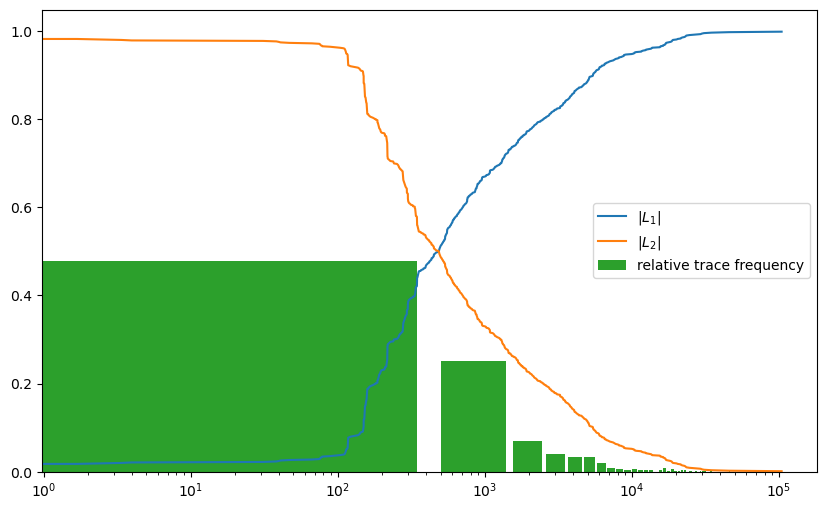

In [26]:
plt.figure(figsize=(10,6))

# plot mmlngld
plt.xscale("log")
plt.plot(sorted_attribute_values[1:], rel_lt_sizes, label=r"$|L_1|$")
plt.plot(sorted_attribute_values[1:], rel_gte_sizes, label=r"$|L_2|$")
plt.hist(sorted_attribute_values[1:], bins=100, weights=rel_freq[1:], rwidth=0.85, label="relative trace frequency")
plt.legend()
plt.savefig(f"out.stats.{file_name}.{attribute_key}.png", bbox_inches="tight")

In [27]:
pd.DataFrame({"l1": rel_lt_sizes, "l2": rel_gte_sizes, "rf": rel_freq[1:]}).to_csv(f"out.stats.{file_name}.{attribute_key}.csv", index=False, header=False)